[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Shape: (25000, 2)
                                              review sentiment
0  My daughter liked it but I was aghast, that a ...       neg
1  I... No words. No words can describe this. I w...       neg
2  this film is basically a poor take on the old ...       neg
3  This is a terrible movie, and I'm not even sur...       neg
4  First of all this movie is a piece of reality ...       pos

🔎 Running GridSearchCV for Logistic Regression ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best Params: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2501
           1       0.87      0.91      0.89      2499

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000


🔎 Running GridSearchCV for Naive Bayes ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best

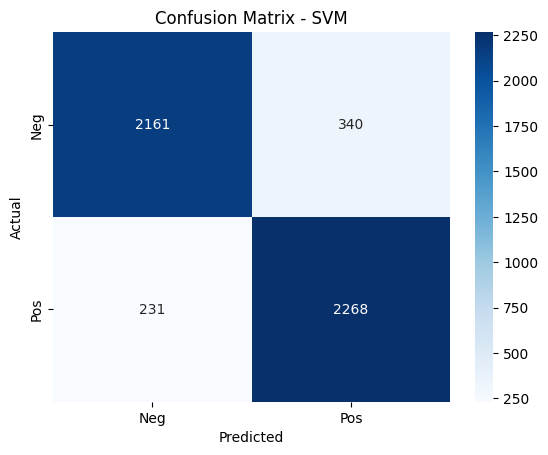


📊 Final Model Comparison:
                                         Best Params Accuracy Precision  \
Logistic Regression  {'C': 1, 'solver': 'liblinear'}   0.8846  0.869331   
Naive Bayes                           {'alpha': 1.0}   0.8506   0.84984   
SVM                     {'C': 0.1, 'max_iter': 1000}   0.8858  0.869632   

                       Recall  F1 Score  
Logistic Regression  0.905162  0.886885  
Naive Bayes          0.851541   0.85069  
SVM                  0.907563  0.888193  


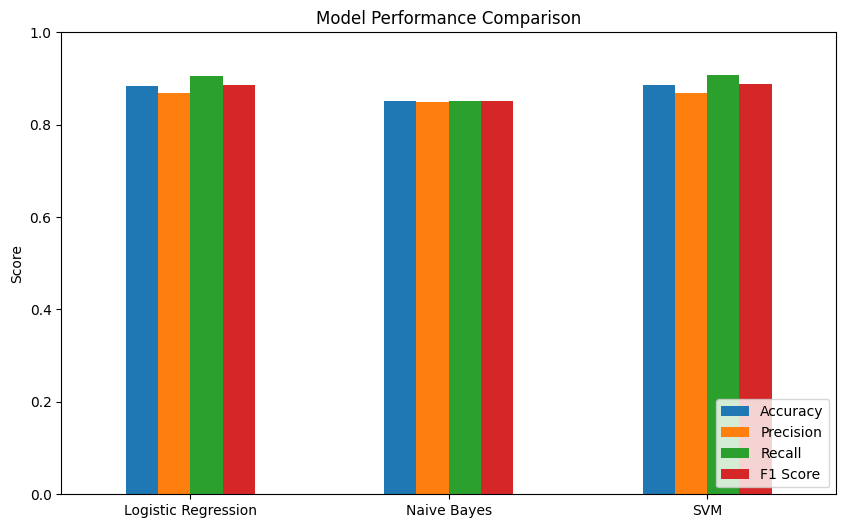

In [3]:
# ======================
# 📌 NLP Classification with Hyperparameter Tuning (GridSearchCV) + Visualization
# ======================

# Install libraries
!pip install scikit-learn nltk

# ======================
# 1. Import Libraries
# ======================
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# 2. Download NLTK Data
# ======================
nltk.download('punkt')
nltk.download('punkt_tab')   # ✅ Fix for latest NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# ======================
# 3. Load Dataset
# ======================
file_path = "/content/drive/MyDrive/movie_reviews.csv"  # change to your path
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print(df.head())

# ======================
# 4. Preprocessing Function
# ======================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# ======================
# 5. Apply Preprocessing
# ======================
X = df['review']
y = df['sentiment'].map({'pos': 1, 'neg': 0})

X_clean = X.apply(lambda x: preprocess_text(str(x)))

# ======================
# 6. Train-Test Split
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42
)

# ======================
# 7. TF-IDF Vectorization
# ======================
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ======================
# 8. Hyperparameter Tuning with GridSearchCV
# ======================
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "saga"]
    },
    "Naive Bayes": {
        "alpha": [0.1, 0.5, 1.0, 5.0]
    },
    "SVM": {
        "C": [0.01, 0.1, 1, 10],
        "max_iter": [1000, 2000]
    }
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

best_models = {}
results = {}

for name, model in models.items():
    print(f"\n🔎 Running GridSearchCV for {name} ...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring="f1", n_jobs=-1, verbose=1)
    grid.fit(X_train_tfidf, y_train)

    best_models[name] = grid.best_estimator_
    y_pred = best_models[name].predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    print(f"✅ Best Params: {grid.best_params_}")
    print(classification_report(y_test, y_pred))

# ======================
# 9. Confusion Matrix for Best Overall Model
# ======================
best_model_name = max(results, key=lambda x: results[x]["F1 Score"])
print(f"\n🏆 Best Model: {best_model_name} with F1 = {results[best_model_name]['F1 Score']:.4f}")

best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# ======================
# 10. Final Results Table
# ======================
results_df = pd.DataFrame(results).T
print("\n📊 Final Model Comparison:")
print(results_df)

# ======================
# 11. Bar Chart Comparison
# ======================
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
results_plot = results_df[metrics]

results_plot.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()
